In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import sys
sys.path.append('./models/')
from SIR import derive, differenciate


In [249]:
# importing mobility from the csv file
df_mobility=pd.read_csv('mobility.csv')
df_mobility.drop(columns=['Unnamed: 0'], inplace=True)
mobility=np.array(df_mobility['mobility'])

df = pd.read_csv('deaths_and_infections.csv')

# remove a columns from a df: 
df.drop(columns=['Unnamed: 0'], inplace=True)
new_deaths=np.array(df['new_deaths'])
n_infected=np.array(df['n_infected'])
death_cumul=np.array([sum(new_deaths[:i]) for i in range(len(new_deaths))])
dates_of_pandemic=np.arange(len(new_deaths))

In [250]:
data =[ new_deaths, n_infected, mobility ]

In [251]:

class Multi_Dimensional_Model: 
    def __init__(self) :
        self.trained=False
    def reinitialize(self): 
        self.trained=False
        self.data=None
        self.train_dates=None
        self.model=None
    def train(self, train_dates, data):
        self.train_dates=train_dates
        self.data=data # to be implemented in the child class
    def predict(self, reach, alphas):
        pass # to be implemented in the child class 

    def plot(self, reach, alpha, title=None): 
        assert self.trained, 'The model has not been trained yet'
        prediction, intervals = self.predict(reach, alpha)
        ci_low=[max(0, intervals[0][i]) for i in range(len(intervals[0]))]
        ci_high=intervals[1]
        plt.plot([i for i in range(len(self.data))], self.data, label='real data')
        plt.plot([i for i in range(len(self.data), len(self.data) + reach)] , prediction, label='forecast ')
        plt.fill_between([i for i in range(len(self.data), len(self.data) + reach)], ci_low, ci_high, color='black', alpha=.3, label='confidence interval at ' + str(round((1-alpha)*100)) + '%')
        plt.legend()
        plt.axvline(len(self.data), linestyle='--')
        plt.xlim(0,len(self.data)+reach)
        plt.title(title)
        plt.show()

In [252]:



def grad_theta_h_m(theta, x): 
    a0=theta[0]
    a1=theta[1]
    a2=theta[2]
    b0=theta[3]
    b1=theta[4]
    b2=theta[5]
    c=theta[6]
    grad=np.zeros(7)
    grad[0]=np.exp(b0*x[0])
    grad[1]=np.exp(b1*x[0])
    grad[2]=np.exp(b2*x[0])
    grad[3]=a0*x[0]*np.exp(b0*x[0])
    grad[4]=a1*x[0]*np.exp(b1*x[0])
    grad[5]=a2*x[0]*np.exp(b2*x[0])
    grad[6]=1
    return grad 

def exponential_function_m(X, a0, a1, a2, b0, b1, b2, c): 
    i, n_infected, mobility = X

    return a0*np.exp(b0*i ) + a1*np.exp(b1*n_infected ) + a2*np.exp(b2*mobility ) + c



In [253]:

class MultiDimensionalExponentialRegression(Multi_Dimensional_Model): 
    def train(self, train_dates, data):
        self.data=data
        train_dates=np.array(train_dates)
        self.train_dates=train_dates
        min=len(data[0])-30
        max=len(data[0])-1
        interval=[i for i in range(min,max)]
        self.interval=interval
        self.p, self.cov =curve_fit(exponential_function_m, (train_dates[interval], data[1][interval], data[2][interval]),data[0][interval],  p0=[ 1,1, 1, 1,1, 1, 1], maxfev = 1000000)
        self.trained=True


    def predict(self, reach, alpha, method='covariance'):
        assert self.trained, 'The model has not been trained yet'
        a0=self.p[0]
        a1=self.p[1]
        a2=self.p[2]
        b0=self.p[3]
        b1=self.p[4]
        b2=self.p[5]
        c=self.p[6]
        window_prediction=np.array([i for i in range(len(self.train_dates), len(self.train_dates) + reach )])
        self.window_prediction=window_prediction
      
        prediction=exponential_function_m(window_prediction, a0, a1, a2,b0, b1, b2,c)
        self.prediction=prediction

        perr = np.sqrt(np.diag(self.cov))
        self.perr=perr     
        ci_low=[]
        ci_high=[]
        grads= []
        vars=[]
        for i in range(len(prediction)):
            index = self.window_prediction[i] 
            grad=grad_theta_h_m(self.p, index)
            grads.append(grad)
            varhtheta=self.cov 
            varprediction=np.matmul(np.matmul(grad.transpose(), varhtheta), grad)
            vars.append(varprediction)
            down = scipy.stats.norm.ppf(alpha/2, loc=prediction[i], scale=np.sqrt(varprediction))
            ci_low.append(down)
            up = scipy.stats.norm.ppf(1-(alpha/2), loc=prediction[i], scale=np.sqrt(varprediction))
            ci_high.append(up)
        self.ci_low=ci_low
        self.ci_high=ci_high
        self.grads=grads
        self.vars=vars
        return prediction, [ci_low, ci_high]




In [254]:
split=40
reach=7

In [255]:
data_train=[data[0][:split], data[1][:split], data[2][:split]]
dates_of_pandemic_train=dates_of_pandemic[:split]

In [256]:

def run_sir_m(x0, a, b , gamma,d, mobility , dt):
    t=len(mobility)
    x=x0
    S=[x[0]]
    I=[x[1]]
    R=[x[2]]
    D=[x[3]] # deads 
    n_iter=int(t/dt)
    N=sum(x0)
    for i in range(n_iter):
        todays_mobility=mobility[int(i*dt)]
        beta=a*todays_mobility+b
        x=x+dt*derive(x, beta, N, gamma, d)
        S.append(x[0])
        I.append(x[1])
        R.append(x[2])
        D.append(x[3])
    s_final=[]
    i_final=[]
    r_final=[]
    d_final=[]
    time=np.linspace(0, t, int(t/dt) )
    for i in range(len(time)-1):
        if abs(time[i]-int(time[i]))<dt: 
            s_final.append(S[i])
            i_final.append(I[i])
            r_final.append(R[i])
            d_final.append(D[i])
    return s_final, i_final, r_final, d_final

def sir_for_optim_m( x, a, b ,d, mobility): # returns firts the number of deaths and then the number of total infected
    
    s_0=1000000 -1
    i_0=1
    r_0=0
    d_0=0
    x0=np.array([s_0, i_0, r_0, d_0])
    dt=0.001

    S, I, R, D = run_sir_m(x0, a, b , 0.2,d, mobility ,   dt)
    zer=np.array([0])
    d_arr=np.array(D)
    return differenciate(np.concatenate((zer,d_arr)))


In [257]:
# def sir_for_optim_m_normalized(x, a, b ,d, mobility): 
#     pred=sir_for_optim_m(x, a, b ,d, mobility)
#     I=pred[:len(pred)//2]
#     D=pred[len(pred)//2:]
#     return np.concatenate(((np.array(I)/max(I)), np.array(D)/max(D)))
    

In [258]:
from scipy.optimize import curve_fit

def f(interval, alpha, beta): 
    return np.concatenate((np.array(alpha*interval-x_obj) , np.array(beta*interval**2-y_obj)))

x_obj = np.array([2, 4, 6, 8, 10])
y_obj = np.array([1, 12, 27, 48, 75])
interval = np.array([1, 2, 3, 4, 5])

popt, pcov = curve_fit(f, interval, np.concatenate((x_obj, y_obj)), p0=[2, 1])

In [259]:


def grad_theta_h_theta(x0, theta, mob_predicted ): 
    reach=len(mob_predicted)-1
    grad=np.zeros((len(theta), reach))
    for i in range(len(grad)): 
        theta_plus=theta.copy()
        theta_plus[i]+=0.0001
        _, _, _, deads_grad = run_sir_m([x0[0], x0[1], x0[2], x0[3]], theta_plus[0], theta_plus[1], 0.2,theta_plus[2] , mob_predicted, 0.001)
        _, _, _, deads= run_sir_m([x0[0], x0[1], x0[2], x0[3]], theta[0], theta[1], 0.2, theta[2], mob_predicted, 0.001)
        d_arr_grad=np.array(differenciate(np.array(deads_grad)))
        d_arr=np.array(differenciate(np.array(deads)))
        grad[i]=(d_arr_grad-d_arr)/0.0001
    return grad


In [260]:

class Multi_SIRD_model(Multi_Dimensional_Model): 
    s_0=1000000 -1
    i_0=1
    r_0=0
    d_0=0
    dt=0.001
    def train(self, train_dates, data):
        self.data=data
        self.train_dates=train_dates
        curve = lambda x, a, b, d : sir_for_optim_m(x, a, b, d, data[2])
        p,cov= curve_fit(curve,np.array([i for i in range(len(train_dates))]),  data[0], p0=[ 1, 1 , 5.523e-04],  bounds=([-np.inf, -np.inf, 0], [np.inf,np.inf, np.inf]))
        self.a=p[0]
        self.b=p[1]
        self.d=p[2]
        self.gamma=0.2
        self.cov=cov
        self.trained= True
    def predict(self, mob_predicted, alpha, method='covariance'):
        reach=len(mob_predicted)
        s_0=1000000 -1
        i_0=1
        r_0=0
        d_0=0
        S,I,R,D=run_sir_m([s_0, i_0, r_0, d_0], self.a, self.b,0.2,  self.d , self.data[2], 0.001)
        self.S=S
        self.I=I
        self.R=R
        self.D=D
        assert self.trained, 'The model has not been trained yet'
        deads=sir_for_optim_m(None, self.a, self.b,self.d, np.concatenate((np.array(self.data[2]), mob_predicted)))
        self.prediction =  deads[-reach:]
        prediction=self.prediction
        if method == 'covariance': 
            perr = np.sqrt(np.diag(self.cov)) # Idea from: https://github.com/philipgerlee/Predicting-regional-COVID-19-hospital-admissions-in-Sweden-using-mobility-data.
        self.perr=perr
        # intervals=[np.array(prediction)]
        # beta_sampled=[]
        # d_sampled=[]
        # for i in range(100):
        #     a=np.random.multivariate_normal([self.beta,self.d], self.cov, 1)[0] # not sampling along gamma because gamma is centered on zero so when we sample along gamma and we resample when the value of one of the component is over zero, we elminiate half of the values and have very bad predictions
        #     while not (a>0).all(): 
        #         a=np.random.multivariate_normal([self.beta,self.d], self.cov, 1)[0]
        #     beta_sampled.append(a[0])
        #     d_sampled.append(a[1])
        #     beta_r=a[0]
        #     d_r=a[1]
        #     _, _, _, deads_sampled = run_sir([self.S[-1], self.I[-1], self.R[-1], self.D[-1]], beta_r, self.gamma, d_r, reach+1, 0.001)
        #     d_arr=np.array(differenciate(np.array(deads_sampled)))
        #     prediction_sampled=d_arr
        #     intervals.append(prediction_sampled)
        # self.beta_sampled=beta_sampled
        # self.d_sampled=d_sampled
        # intervals=np.array(intervals).transpose()
        # self.intervals=intervals
        # ci_low=np.array([np.quantile(intervals[i], alpha/2) for i in range(reach)])
        # ci_high=np.array([np.quantile(intervals[i],1-alpha/2) for i in range(reach)])
        delta_method=True
        if delta_method: 
            print('delta-method')
            ci_low=[]
            ci_high=[]
            grad=grad_theta_h_theta([self.S[-1], self.I[-1], self.R[-1], self.D[-1]], [self.a, self.b , self.d], mob_predicted) # size 3 x reach
            cov=self.cov
            vars=(grad.transpose() @ cov @ grad).transpose()[0]
            assert(len(vars)==reach, str(len(vars)) + 'different from ' + str(reach))
            for i in range(len(vars)): 
                down = scipy.stats.norm.ppf(alpha/2, loc=self.prediction[i], scale=np.sqrt(vars[i]))
                ci_low.append(down)
                up = scipy.stats.norm.ppf(1-(alpha/2), loc=self.prediction[i], scale=np.sqrt(vars[i]))
                ci_high.append(up)
            self.ci_low=ci_low
            self.ci_high=ci_high
        else: 
            print('sampling parameters')
        return prediction, [ci_low, ci_high]

<>:65: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:65: SyntaxWarning: assertion is always true, perhaps remove parentheses?
C:\Users\grego\AppData\Local\Temp\ipykernel_13988\3078276886.py:65: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(vars)==reach, str(len(vars)) + 'different from ' + str(reach))


In [261]:
sird_multi=Multi_SIRD_model()
sird_multi.train(dates_of_pandemic_train, data_train)


In [262]:
mob_predicted=np.array([mobility[split] for i in range(reach)])

In [263]:
pred, intervals=sird_multi.predict(mob_predicted, 0.05)

delta-method


In [264]:
s_0=1000000 -1
i_0=1
r_0=0
d_0=0
dt=0.001

In [265]:
a, b, d= sird_multi.a, sird_multi.b, sird_multi.d 
a,b,d

(0.18660971348068864, 0.6482250388152843, 0.0024401516321360867)

In [266]:
S,I,R,D=run_sir_m([s_0, i_0, r_0, d_0], a, b, 0.2, d, data[2][:split+reach], 0.001)


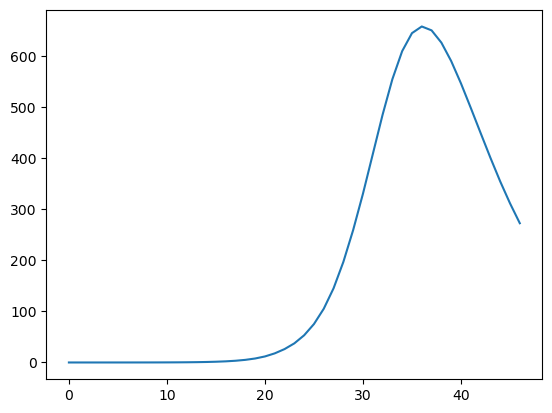

In [267]:
plt.plot(sir_for_optim_m(None, a, b, d, data[2][:split+reach]))

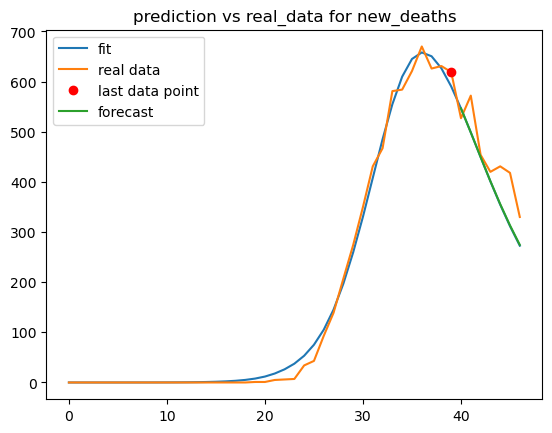

In [270]:

plt.plot(np.concatenate((np.array([0]), differenciate(D))), label='fit')
plt.plot(new_deaths[:split+reach], label='real data')
plt.plot(split-1, new_deaths[split-1], 'ro', label='last data point')
plt.plot([i for i in range(split, split+reach)], pred, label='forecast')
plt.legend()
plt.title('prediction vs real_data for new_deaths')

plt.show()

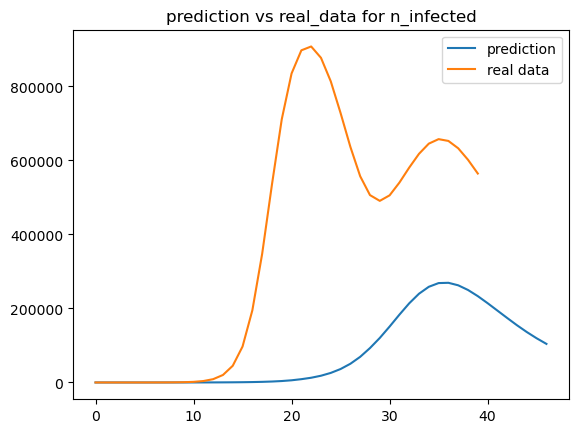

In [269]:
plt.plot(I, label='prediction')
plt.plot(n_infected[:split], label='real data')
plt.legend()
plt.title('prediction vs real_data for n_infected')
plt.show()